### code from task5plot.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm

def compBBox(matX, eps=0.1):
    xmin, xmax = np.min(matX[0]), np.max(matX[0])
    ymin, ymax = np.min(matX[1]), np.max(matX[1])
    dltx, dlty = (xmax - xmin) * eps, (ymax - ymin) * eps

    return {'xmin':xmin-dltx, 'xmax':xmax+dltx,
            'ymin':ymin-dlty, 'ymax':ymax+dlty}



def plot2dDataFnct(matXlist,
                   bboxdict,
                   matS=None,
                   fctF=(None,None,None),
                   cmap=clr.ListedColormap(['C0','C1'], 'indexed'),
                   cmapalph=0.25,
                   showAxes=False,
                   showCont=False,
                   showFnct=True,
                   filename=None,
                   title=None):
    fig = plt.figure()
    axs = fig.add_subplot(111, aspect='equal', facecolor='w')

    setAxes(axs) if showAxes else axs.set_axis_off()
    setLims(axs, bboxdict)

    cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    xstl = {'ls':'', 'marker':'o',
            'ms': 7, 'mew':0, 'mec':'k', 'alpha':0.50}
    sstl = {'ls':'', 'marker':'s', 'fillstyle':'none',
            'ms':11, "mew":1, 'mec':'k', 'alpha':1.00}
    xs, ys, fs = fctF

    if fs is not None and showFnct:
        axs.imshow(fs, interpolation='bicubic', origin='lower',
                   extent=(bboxdict['xmin'], bboxdict['xmax'],
                           bboxdict['ymin'], bboxdict['ymax']),
                   cmap=cmap, norm=clr.TwoSlopeNorm(0), alpha=cmapalph)


    # plot data points in data matrices
    for i, matX in enumerate(matXlist):
        xstl['c'] = 'k' if len(matXlist) <= 1 else cols[i%10]
        axs.plot(matX[0], matX[1], **xstl)


    # plot support vectors in matrix S
    if matS is not None:
        axs.plot(matS[0,:], matS[1,:], **sstl)

    # plot zero contour line
    if xs is not None and \
       ys is not None and \
       fs is not None and \
       showCont:
        axs.contour(xs, ys, fs, [0], colors='k', alpha=1.00)

    plt.title(title) if title is not None else None

    plt.show() if filename is None else writeFigure(fig, filename)
    plt.close()





def setLims(axs, bboxdict):
    axs.set_xlim(bboxdict['xmin'], bboxdict['xmax'])
    axs.set_ylim(bboxdict['ymin'], bboxdict['ymax'])



def setAxes(axs):
    for a in ['right', 'top']:
        axs.spines[a].set_visible(False)
    for a in ['left', 'bottom']:
        axs.spines[a].set_alpha(1)
        axs.spines[a].set_zorder(0)
        axs.spines[a].set_color('k')
        axs.spines[a].set_linewidth(1)
        axs.spines[a].set_position('zero')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')



def writeFigure(fig, fname, pad=0.1):
    fmt = fname.split('.')[-1]
    fig.savefig(fname)
        # , facecolor=fig.get_facecolor(), edgecolor='w',
        #         format=fmt, transparent=False,
        #         bbox_inches='tight', pad_inches=pad)



### Code from the lecture

In [2]:
import scipy.spatial as spt
def SQEDMAB(A,B):
    """
    if matrices A and B are of shapes (m, na) and (m, nb), then this
    functions returns a squared distance matrix of shape (na, nb)
    """
    return spt.distance.cdist(A.T, B.T, 'sqeuclidean')

def gaussKernelVector(matXtst, matXtrn, **kPars):
    sigm = kPars['sigm'] if 'sigm' in kPars else 1

    if matXtst.ndim == 1:
        dist = np.sum((matXtrn.T-matXtst)**2, axis=1)
    else:
        dist = SQEDMAB(matXtst, matXtrn)
    return np.exp(-0.5/sigm**2 * dist)

def gaussKernelMatrix(matX, **kPars):
    sigm = kPars['sigm'] if 'sigm' in kPars else 1
    return np.exp(-0.5/sigm**2 * SQEDMAB(matX, matX))

In [3]:
def trainKernelL2SVM(matX, vecY, kFct, kPars, C=1., T=10_000):
    matK = kFct(matX, **kPars)
    _, n = matK.shape
    matI = np.eye(n)
    matY = np.outer(vecY, vecY)
    matM = matK * matY + matY + matI / C
    vecM = np.ones(n) / n

    for t in range(T):
        beta = 2 / (t+2)
        grad = matM @ vecM
        vecM += beta * (matI[np.argmin(grad)] - vecM)

    ### return support vectors, their labels and Lagarange multipliers
    return matX[:,vecM>0], vecY[vecM>0], vecM[vecM>0]

In [4]:
def compDecFnct(matX, vecY, vecM, kFct, kPars, bbox, nx=512):
    w = bbox['xmax'] - bbox['xmin']
    h = bbox['ymax'] - bbox['ymin']
    ny = int(nx*h/w)
    xs, ys = np.meshgrid(np.linspace(bbox['xmin'], bbox['xmax'], nx),
    np.linspace(bbox['ymin'], bbox['ymax'], ny))
    matXtst = np.vstack((xs.flatten(), ys.flatten()))
    vecKtst = kFct(matXtst, matX, **kPars)
    vecYtst = np.sign(np.sum(vecKtst * vecY * vecM, axis=1) + vecY @ vecM)
    ### return a triple of arrays of pixel x- and y-coordinates
    ### and of the correspponding function values f(x,y)
    return xs, ys, vecYtst.reshape(ny, nx)

## Polynomial kernel functions

In [5]:
def polyKernelVector(matXtst, matXtrn, **kPars):
    deg = kPars['deg'] if 'deg' in kPars else 1
    return (matXtst.T @ matXtrn + 1)**deg

def polyKernelMatrix(matX, **kPars):
    deg = kPars['deg'] if 'deg' in kPars else 1
    return (matX.T @ matX + 1)**deg

## Dataset generation

The files twoMoons-X-trn.csv and twoMoons-y-trn.csv were missing from the assignment.
We will generate the moons dataset ourselves, trying to match the plot from the exercise sheet:

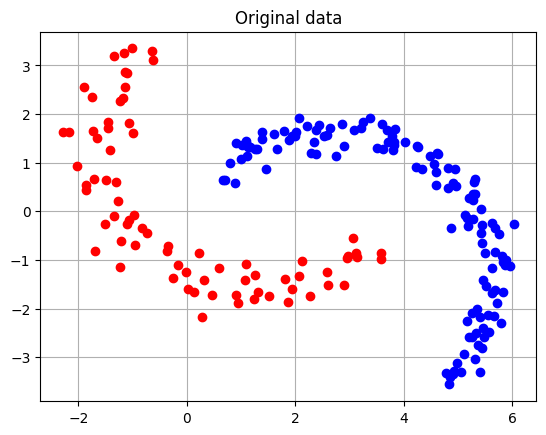

In [18]:
with open('twoMoons-X-trn.csv', 'r') as f:
    matX = f.readlines()

    for i in range(len(matX)):
        matX[i] = matX[i].split(',')
        for j in range(len(matX[i])):
            matX[i][j] = float(matX[i][j])
    matX = np.array(matX)

with open('twoMoons-y-trn.csv', 'r') as f:
    vecY = f.readlines()

    for i in range(len(vecY)):
        vecY[i] = int(vecY[i])

    vecY = np.array(vecY)

# plot matX with vecY as labels
plt.plot(matX[0,vecY<=0], matX[1,vecY<=0], 'bo')
plt.plot(matX[0,vecY>0], matX[1,vecY>0], 'ro')
plt.title('Original data')

# add grid
plt.grid(True)

plt.show()

In [15]:
def train_classifier(kParams, kMatFct, kVecFct, title):

    ### compute support vectors, their labels, and Lagrange multipliers
    matXs, vecYs, vecMs = trainKernelL2SVM(matX, vecY, kMatFct, kParams, C=100.)

    ### extract class specific training data for plotting
    X1 = matX[:,vecY<=0]
    X2 = matX[:,vecY>0]
    ### compute bounding box of training data for plotting
    bbox = compBBox(matX)
    ### compute decision function for plotting
    decFnct = compDecFnct(matXs, vecYs, vecMs, kVecFct, kParams, bbox)

    plot2dDataFnct([X1, X2], bbox, showAxes=True, title=title)
    plot2dDataFnct([X1, X2], bbox, fctF=decFnct, showAxes=True, title=title + ' decision function')
    plot2dDataFnct([X1, X2], bbox, fctF=decFnct, showAxes=False, showCont=True, title=title + ' decision function and contour')

## Gaussian kernel

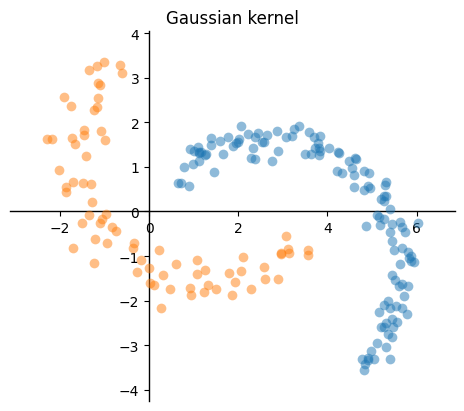

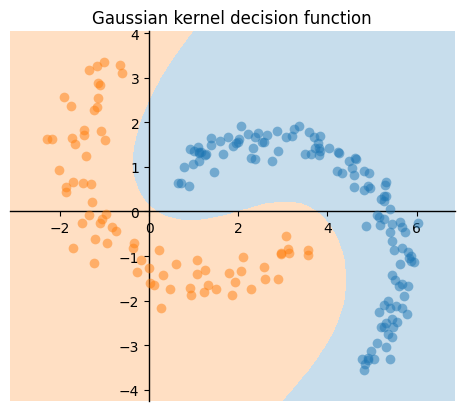

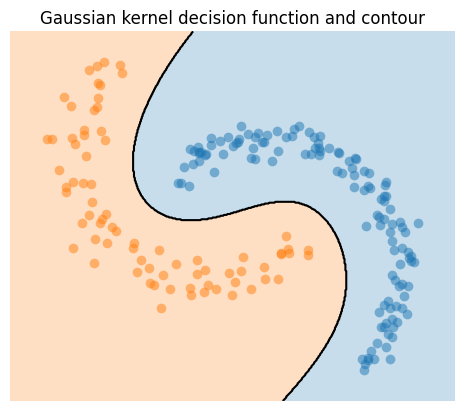

In [16]:
### kernel parameters and functions
kParams = {'sigm' : 2.}
kMatFct = gaussKernelMatrix
kVecFct = gaussKernelVector

train_classifier(kParams, kMatFct, kVecFct, 'Gaussian kernel')

## Polynomial kernel

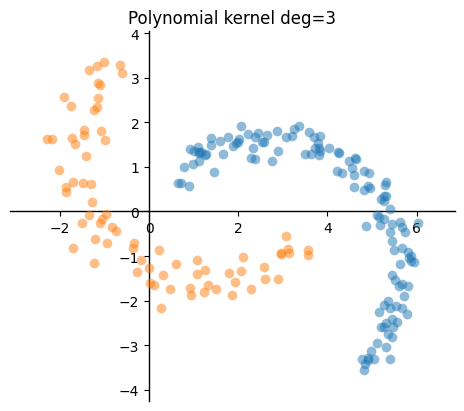

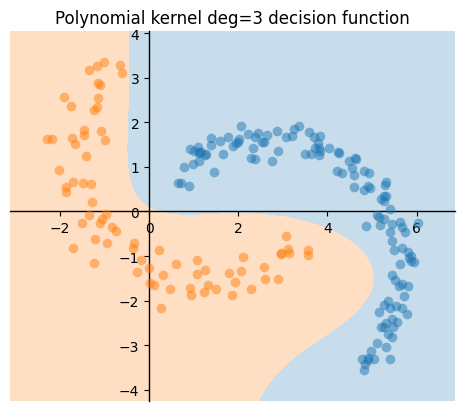

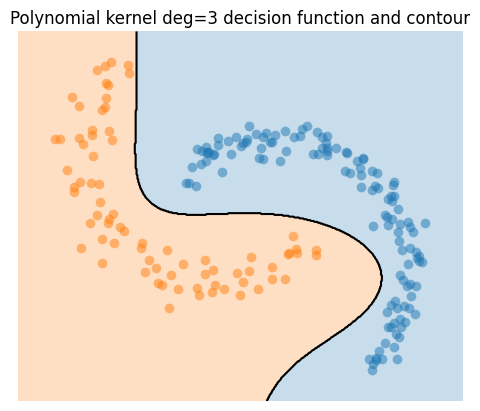

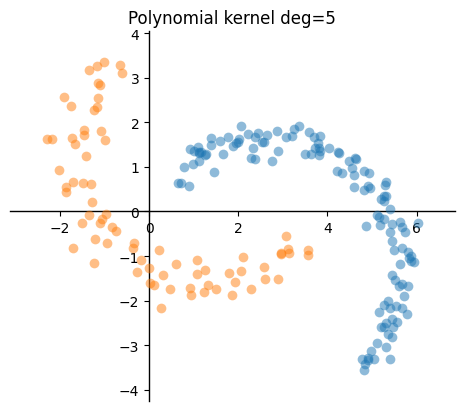

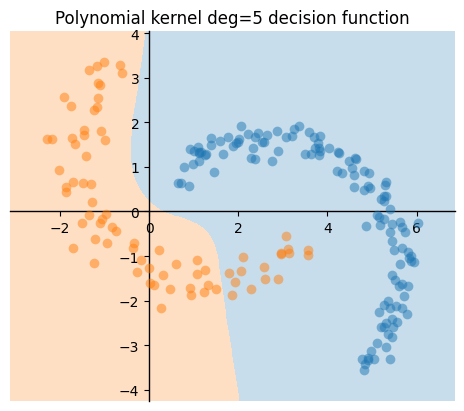

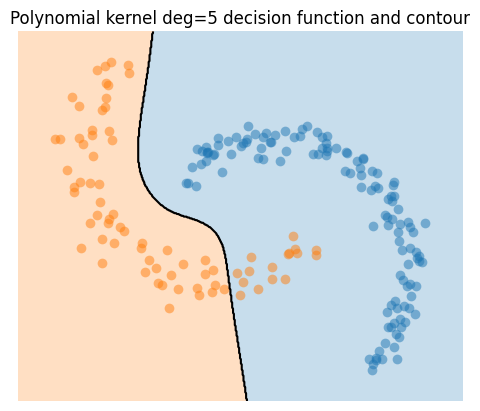

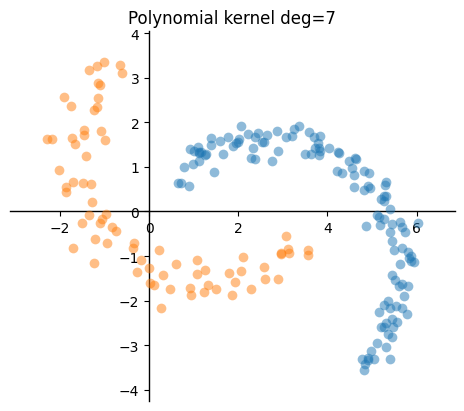

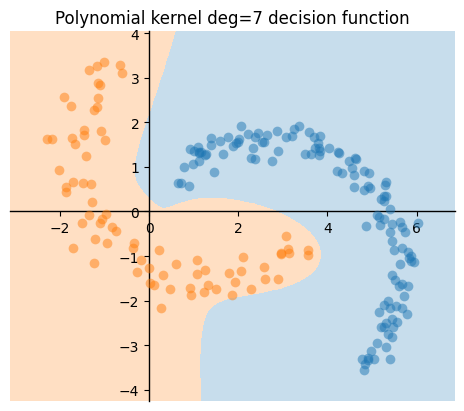

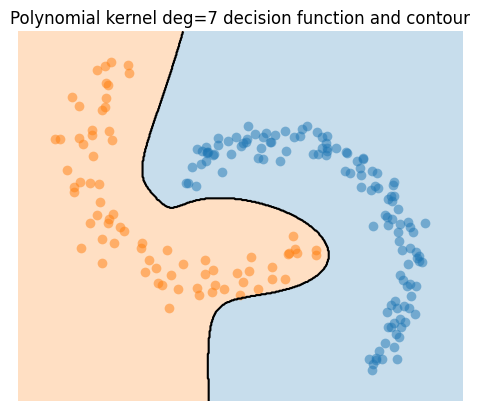

In [17]:
for deg in [3, 5, 7]:
    kParams = {'deg' : deg}
    kMatFct = polyKernelMatrix
    kVecFct = polyKernelVector

    train_classifier(kParams, kMatFct, kVecFct, 'Polynomial kernel deg=' + str(deg))